# Dataloading

In [ ]:
!wget -nc https://raw.githubusercontent.com/girafe-ai/ml-mipt/master/datasets/Machine_translation_EN_RU/data.txt

--2022-05-03 16:31:35--  https://raw.githubusercontent.com/girafe-ai/ml-mipt/master/datasets/Machine_translation_EN_RU/data.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12905334 (12M) [text/plain]
Saving to: ‘data.txt’

data.txt            100%[===================>]  12.31M  --.-KB/s    in 0.1s    

2022-05-03 16:31:36 (115 MB/s) - ‘data.txt’ saved [12905334/12905334]



In [ ]:
file_name = 'data.txt'
with open(file_name) as file:
    data = [line.strip().split('\t') for line in file]

data[:3]

[['Cordelia Hotel is situated in Tbilisi, a 3-minute walk away from Saint Trinity Church.',
  'Отель Cordelia расположен в Тбилиси, в 3 минутах ходьбы от Свято-Троицкого собора.'],
 ['At Tupirmarka Lodge you will find a 24-hour front desk, room service, and a snack bar.',
  'В числе удобств лоджа Tupirmarka круглосуточная стойка регистрации и снэк-бар. Гости могут воспользоваться услугой доставки еды и напитков в номер.'],
 ['Featuring free WiFi in all areas, Naigao Xiaowo offers accommodation in Shanghai.',
  'Апартаменты Naigao Xiaowo расположены в городе Шанхай. К услугам гостей бесплатный Wi-Fi во всех зонах.']]

# Data preprocessing

In [ ]:
import numpy as np
import torch
from torch.utils.data import random_split

np.random.seed(42)
torch.random.manual_seed(42)
torch.cuda.random.manual_seed(42)
torch.cuda.random.manual_seed_all(42)

In [ ]:
data_size = len(data)
train_size = int(0.8 * data_size)
test_size = int(0.15 * data_size)
val_size = data_size - train_size - test_size

train_data, test_data, val_data = random_split(
    data, [train_size, test_size, val_size]
)

print(f'train_size: {len(train_data)}')
print(f'val_size: {len(val_data)}')
print(f'test_size: {len(test_data)}')

train_size: 40000
val_size: 2500
test_size: 7500


## Vocabulary

In [ ]:
from nltk import WordPunctTokenizer

In [ ]:
def tokenize(sent):
    return WordPunctTokenizer().tokenize(sent.lower())

In [ ]:
from collections import defaultdict

In [ ]:
def build_counters(tokens):

    en_counter = defaultdict(int)
    ru_counter = defaultdict(int)

    for en_list, ru_list in tokens:

        for en_token in tokenize(en_list):
            en_counter[en_token] += 1
        
        for ru_token in tokenize(ru_list):
            ru_counter[ru_token] += 1
    
    return en_counter, ru_counter


def build_dicts(tokens, special_tokens, en_counter, ru_counter):

    en_token_to_idx = dict()
    en_idx_to_token = []
    en_idx = 0

    ru_token_to_idx = dict()
    ru_idx_to_token = []
    ru_idx = 0

    for token in special_tokens:

        if token not in en_token_to_idx:
            en_token_to_idx[token] = en_idx
            en_idx_to_token.append(token)
            en_idx += 1

        
        if token not in ru_token_to_idx:
            ru_token_to_idx[token] = ru_idx
            ru_idx_to_token.append(token)
            ru_idx += 1
    
    for en_list, ru_list in tokens:

        for en_token in tokenize(en_list):

            if en_counter[en_token] > 2 and en_token not in en_token_to_idx:
                en_token_to_idx[en_token] = en_idx
                en_idx_to_token.append(en_token)
                en_idx += 1
        
        for ru_token in tokenize(ru_list):

            if ru_counter[ru_token] > 2 and ru_token not in ru_token_to_idx:
                ru_token_to_idx[ru_token] = ru_idx
                ru_idx_to_token.append(ru_token)
                ru_idx += 1
    
    return en_token_to_idx, en_idx_to_token, ru_token_to_idx, ru_idx_to_token


In [ ]:
en_counter, ru_counter = build_counters(train_data)

special_tokens = ['<unk>', '<sos>', '<eos>']
en_token_to_idx, en_idx_to_token, ru_token_to_idx, ru_idx_to_token = build_dicts(train_data, special_tokens, en_counter, ru_counter)

In [ ]:
print(f'en_vocab_size: {len(en_token_to_idx)}')
print(f'ru_vocab_size: {len(ru_token_to_idx)}')

en_vocab_size: 6710
ru_vocab_size: 9309


## Dataset and Dataloader

In [ ]:
from torch.utils.data import Dataset, DataLoader

In [ ]:
class TranslationDataset(Dataset):

    def __init__(self, pairs_of_sentences, en_token_to_idx, ru_token_to_idx, presort=False):

        self.pairs_of_tokenized_sentences = [
            (
                [
                    en_token_to_idx[token]
                    if token in en_token_to_idx
                    else en_token_to_idx['<unk>']
                    for token in
                    tokenize(pair[0])
                ],
                [
                    ru_token_to_idx[token]
                    if token in ru_token_to_idx
                    else ru_token_to_idx['<unk>']
                    for token in
                    tokenize(pair[1])
                ]
            )
            for pair in pairs_of_sentences
        ]

        if presort:
            self.pairs_of_tokenized_sentences = sorted(self.pairs_of_tokenized_sentences, key=lambda pair: len(pair[0]))
    
    def __getitem__(self, idx):

        pair = self.pairs_of_tokenized_sentences[idx]

        src = [en_token_to_idx['<sos>']] + pair[0] +[en_token_to_idx['<eos>']]
        trg = [ru_token_to_idx['<sos>']] + pair[1] + [ru_token_to_idx['<eos>']]

        return torch.LongTensor(src), torch.LongTensor(trg)
    
    def __len__(self):

        return len(self.pairs_of_tokenized_sentences)

In [ ]:
train_trans_dataset = TranslationDataset(train_data, en_token_to_idx, ru_token_to_idx, presort=True)
val_trans_dataset = TranslationDataset(val_data, en_token_to_idx, ru_token_to_idx, presort=True)
test_trans_dataset = TranslationDataset(test_data, en_token_to_idx, ru_token_to_idx, presort=True)

In [ ]:
class PaddingCollator:

    def __init__(self, en_pad_idx, ru_pad_idx, batch_first=True):

        self.en_pad_idx = en_pad_idx
        self.ru_pad_idx = ru_pad_idx
        self.batch_first = batch_first

    def __call__(self, batch):

        en_max_len = max(map(lambda pair: len(pair[0]), batch))
        ru_max_len = max(map(lambda pair: len(pair[1]), batch))

        en_size = (len(batch), en_max_len)
        ru_size = (len(batch), ru_max_len)

        en_batch = torch.full(size=en_size, fill_value=self.en_pad_idx)
        ru_batch = torch.full(size=ru_size, fill_value=self.ru_pad_idx)

        for i, (src, trg) in enumerate(batch):

            en_batch[i, :len(src)] = src
            ru_batch[i, :len(trg)] = trg
        
        if not self.batch_first:

            en_batch = en_batch.permute(1, 0)
            ru_batch = ru_batch.permute(1, 0)

        return en_batch, ru_batch


In [ ]:
batch_size = 128

train_trans_loader = DataLoader(
    train_trans_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
    collate_fn=PaddingCollator(
        en_pad_idx=en_token_to_idx['<eos>'],
        ru_pad_idx=ru_token_to_idx['<eos>'],
        batch_first=True
    )
)
val_trans_loader = DataLoader(
    val_trans_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
    collate_fn=PaddingCollator(
        en_pad_idx=en_token_to_idx['<eos>'],
        ru_pad_idx=ru_token_to_idx['<eos>'],
        batch_first=True
    )
)
test_trans_loader = DataLoader(
    test_trans_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
    collate_fn=PaddingCollator(
        en_pad_idx=en_token_to_idx['<eos>'],
        ru_pad_idx=ru_token_to_idx['<eos>'],
        batch_first=True
    )
)

# Model

In [ ]:
import torch
import torch.nn as nn

## Attention

In [ ]:
class MHALayer(nn.Module):
    
    def __init__(self, hid_size, n_heads, dropout, device):
        super().__init__()
        
        self.fc_q = nn.Linear(hid_size, hid_size)
        self.fc_k = nn.Linear(hid_size, hid_size)
        self.fc_v = nn.Linear(hid_size, hid_size)

        self.fc_o = nn.Linear(hid_size, hid_size)
        self.dropout = nn.Dropout(dropout)

        self.hid_size = hid_size
        self.n_heads = n_heads
        self.head_size = hid_size // n_heads

        self.scale = torch.sqrt(torch.FloatTensor([self.head_size])).to(device)

    def forward(self, q, k, v, mask=None):

        # q: [b_size, seq_len, hid_size]

        b_size = q.shape[0]

        Q = self.fc_q(q) # [b_size, seq_len, hid_size]
        K = self.fc_k(k)
        V = self.fc_v(v)

        Q = Q.view(b_size, -1, self.n_heads, self.head_size).permute(0, 2, 1, 3) # [b_size, n_heads seq_len, head_size]
        K = K.view(b_size, -1, self.n_heads, self.head_size).permute(0, 2, 1, 3)
        V = V.view(b_size, -1, self.n_heads, self.head_size).permute(0, 2, 1, 3)

        energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale # [b_size, n_heads seq_len, seq_len]
        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e10)
        
        attention = torch.softmax(energy, dim=-1) # [b_size, n_heads seq_len, seq_len]

        x = torch.matmul(self.dropout(attention), V) # [b_size, n_heads seq_len, head_size]
        x = x.permute(0, 2, 1, 3).contiguous() # [b_size, seq_len, n_heads, head_size]
        x = x.view(b_size, -1, self.hid_size) # [b_size, seq_len, hid_size]

        return self.fc_o(x)


In [ ]:
class FeedForward(nn.Module):

    def __init__(self, hid_size, inter_size, dropout):
        super().__init__()

        self.fc_1 = nn.Linear(hid_size, inter_size)
        self.fc_2 = nn.Linear(inter_size, hid_size)

        self.gelu = nn.GELU()
        self.dropout = nn.Dropout(dropout)

    def forward(self, emb): # emb: [b_size, seq_len, hid_size]

        output = self.dropout(self.gelu(self.fc_1(emb)))
        return self.fc_2(output)

## Encoder

In [ ]:
class EncoderLayer(nn.Module):

    def __init__(self, hid_size, n_heads, inter_size, dropout, device):
        super().__init__()

        self.mhsa = MHALayer(hid_size, n_heads, dropout, device)
        self.mhsa_layer_norm = nn.LayerNorm(hid_size)

        self.ff = FeedForward(hid_size, inter_size, dropout)
        self.ff_layer_norm = nn.LayerNorm(hid_size)

        self.dropout = nn.Dropout(dropout)

    def forward(self, src_emb, src_mask):

        _src_emb = self.mhsa(src_emb, src_emb, src_emb, src_mask)
        src_emb = self.mhsa_layer_norm(self.dropout(_src_emb) + src_emb)

        _src_emb = self.ff(src_emb)
        src_emb = self.ff_layer_norm(self.dropout(_src_emb) + src_emb)

        return src_emb
        

In [ ]:
class Encoder(nn.Module):

    def __init__(self, hid_size, n_heads, inter_size, dropout, device, n_layers, voc_size, max_len=120):
        super().__init__()

        self.token_emb = nn.Embedding(voc_size, hid_size)
        self.pos_emb = nn.Embedding(max_len, hid_size)

        self.layers = nn.ModuleList([
            EncoderLayer(hid_size, n_heads, inter_size, dropout, device)
            for _ in range(n_layers)
        ])

        self.device = device
        
        self.scale = torch.sqrt(torch.FloatTensor([hid_size])).to(device)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, src, src_mask):

        token_emb = self.token_emb(src) # [b_size, seq_len, hid_size]
        pos = torch.arange(token_emb.shape[1]).unsqueeze(0).to(self.device) # [1, seq_len]

        pos_emb = self.pos_emb(pos) # [1, seq_len, hid_size]

        emb = self.dropout(token_emb * self.scale  + pos_emb)

        for layer in self.layers:
            emb = layer(emb, src_mask)

        return emb


## Decoder

In [ ]:
class DecoderLayer(nn.Module):

    def __init__(self, hid_size, n_heads, inter_size, dropout, device):
        super().__init__()

        self.mhsa = MHALayer(hid_size, n_heads, dropout, device)
        self.mhsa_layer_norm = nn.LayerNorm(hid_size)
       
        self.mha = MHALayer(hid_size, n_heads, dropout, device)
        self.mha_layer_norm = nn.LayerNorm(hid_size)

        self.ff = FeedForward(hid_size, inter_size, dropout)
        self.ff_layer_norm = nn.LayerNorm(hid_size)

        self.dropout = nn.Dropout(dropout)

    def forward(self, trg, src, trg_mask, src_mask):

        # trg: [b_size, trg_len, hid_size]
        # src: [b_size, src_len, hid_size]
        # trg_mask: [b_size, 1, trg_len, trg_len]
        # src_mask: [b_size, 1, 1, src_len]

        # self attention
        _trg = self.mhsa(trg, trg, trg, trg_mask)
        trg = self.mhsa_layer_norm(self.dropout(_trg) + trg)

        # encoder-decoder attention
        _trg = self.mha(trg, src, src, src_mask)
        trg = self.mha_layer_norm(self.dropout(_trg) + trg)
        
        _trg = self.ff(trg)
        trg = self.ff_layer_norm(self.dropout(_trg) + trg)

        return trg

In [ ]:
class Decoder(nn.Module):

    def __init__(self, hid_size, n_heads, inter_size, dropout, device, n_layers, voc_size, max_len=120):
        super().__init__()

        self.token_emb = nn.Embedding(voc_size, hid_size)
        self.pos_emb = nn.Embedding(max_len, hid_size)

        self.layers = nn.ModuleList([
            DecoderLayer(hid_size, n_heads, inter_size, dropout, device)
            for _ in range(n_layers)
        ])

        self.device = device

        self.scale = torch.sqrt(torch.FloatTensor([hid_size])).to(device)
        self.dropout = nn.Dropout(dropout)

        self.hid_size = hid_size
        self.voc_size = voc_size
    
    def forward(self, trg, src_emb, trg_mask, src_mask):

        token_emb = self.token_emb(trg) # [b_size, seq_len, hid_size]
        pos = torch.arange(token_emb.shape[1]).unsqueeze(0).to(self.device) # [1, seq_len]
        pos_emb = self.pos_emb(pos) # [1, seq_len, hid_size]

        emb = self.dropout(token_emb * self.scale  + pos_emb)

        for layer in self.layers:
            emb = layer(emb, src_emb, trg_mask, src_mask)

        return emb


## Seq2Seq

In [ ]:
import random

In [ ]:
class Seq2Seq(nn.Module):

    def __init__(self, encoder, decoder, src_pad_idx, trg_pad_idx, device):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.to_logits = nn.Linear(decoder.hid_size, decoder.voc_size)

        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx

        self.device = device
    
    def make_src_mask(self, src): # [b_size, src_len]

        mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2) # [b_size, 1, 1, src_len]
        return mask.to(self.device)
    
    def make_trg_mask(self, trg): # [b_size, trg_len]

        mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2) # [b_size, 1, 1, trg_len]

        trg_len = trg.shape[1]
        mask = mask.repeat(1, 1, trg_len, 1) # [b_size, 1, trg_len, trg_len]

        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len))).bool().to(self.device) # [trg_len, trg_len]

        return (mask & trg_sub_mask)
    
    def forward(self, src, trg): # [b_size, seq_len]

        src_mask = self.make_src_mask(src) # [b_size, 1, 1, src_len]
        trg_mask = self.make_trg_mask(trg) # [b_size, 1, trg_len, trg_len]

        src_emb = self.encoder(src, src_mask) # [b_size, src_len, hid_size]
        
        output = self.decoder(trg, src_emb, trg_mask, src_mask) # [b_size, trg_len, hid_size]

        return self.to_logits(output) # [b_size, trg_len, voc_size]


## Model

In [ ]:
en_max_len = max(len(train_trans_dataset[-1][0]), len(val_trans_dataset[-1][0]), len(test_trans_dataset[-1][0]))
ru_max_len = max(
    len(max(train_trans_dataset, key=lambda pair: len(pair[1]))[1]),
    len(max(val_trans_dataset, key=lambda pair: len(pair[1]))[1]),
    len(max(test_trans_dataset, key=lambda pair: len(pair[1]))[1])
)
print(f'en_max_len: {en_max_len}')
print(f'ru_max_len: {ru_max_len}')

en_max_len: 101
ru_max_len: 82


In [ ]:
hid_size = 256
n_heads = 4
inter_size = 512
dropout = 0.3
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
encoder = Encoder(hid_size, n_heads, inter_size, dropout, device, n_layers=4, voc_size=len(en_token_to_idx), max_len=en_max_len)
decoder = Decoder(hid_size, n_heads, inter_size, dropout, device, n_layers=4, voc_size=len(ru_token_to_idx), max_len=ru_max_len)

model = Seq2Seq(encoder, decoder, en_token_to_idx['<eos>'], ru_token_to_idx['<eos>'], device).to(device)

# Training

In [ ]:
import matplotlib.pyplot as plt
from IPython.display import clear_output
from tqdm import tqdm

In [ ]:
class Trainer:

    def __init__(self, model, opt, criterion, device):

        self.model = model.to(device)
        self.opt = opt
        self.criterion = criterion
    
        self.device = device

        self.n_epochs = 0
        self.train_loss_history = []
        self.val_loss_history = []
    
    def train(self, train_loader, val_loader, n_epochs):

        for _ in range(n_epochs):

            self.train_iter(train_loader)
            self.val_iter(val_loader)
            self.n_epochs += 1
        
    def train_iter(self, loader):

        self.model.train()

        n_iter = 0

        for src, trg in tqdm(loader):
            src, trg = src.to(device), trg.to(device)

            self.opt.zero_grad()

            logits = self.model(src, trg[:, :-1]) # [b_size, trg_len - 1, ru_voc_size]
            logits = logits.permute(0, 2, 1) # [b_size, ru_voc_size, trg_len - 1]

            loss = self.criterion(logits, trg[:, 1:].long())
            
            loss.backward()
            self.opt.step()

            self.train_loss_history.append(loss.item())

            n_iter += 1
            if (n_iter + 1) % 10 == 0:
                clear_output(wait=True)
                plt.plot(self.train_loss_history, label='train_loss')
                plt.plot(self.val_loss_history, label='val_loss')
                plt.legend()
                plt.show() 

    def val_iter(self, loader):

        self.model.eval()

        n_iter = 0

        with torch.no_grad():

            for src, trg in loader:
                src, trg = src.to(device), trg.to(device)

                logits = self.model(src, trg[:, :-1]) # [b_size, trg_len - 1, ru_voc_size]
                logits = logits.permute(0, 2, 1) # [b_size, ru_voc_size, trg_len - 1]

                loss = self.criterion(logits, trg[:, 1:].long())

                self.val_loss_history.append(loss.item())

                n_iter += 1
                if (n_iter + 1) % 10 == 0:
                    clear_output(wait=True)
                    plt.plot(self.train_loss_history, label='train_loss')
                    plt.plot(self.val_loss_history, label='val_loss')
                    plt.legend()
                    plt.show() 

In [ ]:
opt = torch.optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

In [ ]:
trainer = Trainer(model, opt, criterion, device)

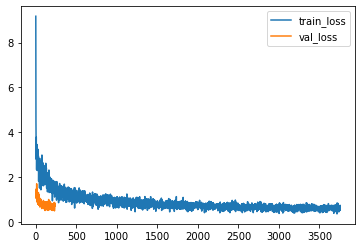

In [ ]:
trainer.train(train_trans_loader, val_trans_loader, 4)

In [ ]:
print(f'train_loss: {np.mean(np.asarray(trainer.train_loss_history[-20:]))}')
print(f'val_loss: {np.mean(np.asarray(trainer.val_loss_history[-5:]))}')

train_loss: 0.5984236359596252
val_loss: 0.7784892439842224


In [ ]:
torch.save(model.state_dict(), 'nmt_model.state_dict')

# Inference

In [ ]:
tokenizer.decode('hello, how are you?', ч)

In [ ]:
def translate(sent, model, en_token_to_idx, ru_token_to_idx, ru_idx_to_token, device, max_len):

    model.eval()

    with torch.no_grad():

        tokens = tokenize(sent)
        src = [en_token_to_idx[token] if token in en_token_to_idx else en_token_to_idx['<unk>'] for token in tokens]
        src = torch.LongTensor(src).unsqueeze(0).to(device)

        src_mask = model.make_src_mask(src)
        enc_src = model.encoder(src, src_mask)

        trg_indices = [en_token_to_idx['<sos>']]

        for i in range(max_len):

            trg = torch.LongTensor(trg_indices).unsqueeze(0).to(device)
            trg_mask = model.make_trg_mask(trg)
            logits = model.to_logits(model.decoder(trg, enc_src, trg_mask, src_mask))

            pred_token = logits.argmax(2)[:, -1].item()

            if pred_token == ru_token_to_idx['<eos>']:
                break

            trg_indices.append(pred_token)

        
        trg_tokens = [ru_idx_to_token[idx] for idx in trg_indices]
    
    return ' '.join(trg_tokens[1:])


In [ ]:
idx = 0
src, trg = train_data[idx]
pred = translate(src, model, en_token_to_idx, ru_token_to_idx, ru_idx_to_token, device, max_len=60)
print(src)
print(trg)
print(pred)

Each has a bathroom with a bath and a shower, as well as a minibar and a TV.
В распоряжении гостей мини-бар, телевизор и ванная комната с ванной и душем.
в каждом номере есть телевизор , мини - бар , ванная комната с ванной , душем , феном и ванной .


In [ ]:
start = 100
for idx in range(start, start + 10):

    src, trg = test_data[idx]
    pred = translate(src, model, en_token_to_idx, ru_token_to_idx, ru_idx_to_token, device, max_len=60)
    print(src)
    print(trg)
    print(pred)
    print()

There is also a kitchen, equipped with an oven. A fridge and stovetop are also offered, as well as a kettle.
В распоряжении гостей кухня с духовкой, холодильником, плитой и чайником.
кухня оснащена духовкой , холодильником , плитой , плитой , плитой , чайником и чайником .

Towels are featured.
Гостям предоставляются полотенца.
гостям предоставляются полотенца и постельное белье .

Offering direct access to beautiful Ao Kratueng Beach, Makathanee Resort is located on the island of Koh Mak.
Курортный отель Makathanee с прямым выходом на прелестный пляж Ао Кратуэнг расположен на острове Ко Мак.
курортный отель <unk> <unk> <unk> <unk> island расположен на берегу озера <unk> , рядом с пляжем в окружении пляжа <unk> .

The main bus station can be reached within a 5-minute walk and the city hall is just 50 metres away.
До главного автобусного вокзала можно дойти за 5 минут. Расстояние до городской ратуши составляет всего 50 метров.
до главного автобусного вокзала и автобусного вокзалов можно

# BLEU

In [ ]:
from nltk.translate.bleu_score import corpus_bleu

model.to(device)
model.eval()

references, hypotheses = [], []
with torch.no_grad():
    for src, trg in test_trans_loader:
        output = model(src.to(device), trg.to(device))
        output = output.cpu().numpy().argmax(axis=2)

        for i in range(trg.shape[0]):
            reference = trg[i, :]
            reference_tokens = [ru_idx_to_token[id_] for id_ in reference]
            reference_tokens = [tok for tok in reference_tokens if tok not in special_tokens]
            references.append(reference_tokens)

            hypothesis = output[i, :]
            hypothesis_tokens = [ru_idx_to_token[id_] for id_ in hypothesis]
            hypothesis_tokens = [tok for tok in hypothesis_tokens if tok not in special_tokens]
            hypotheses.append(hypothesis_tokens)

# corpus_bleu works with multiple references
bleu = corpus_bleu([[ref] for ref in references], hypotheses)
print(f"Your model shows test BLEU of {100 * bleu:.1f}")

Your model shows test BLEU of 35.1
